##### Importing Libraries

In [48]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

##### Import the training set

In [49]:
df_train = pd.read_csv('Google_Stock_Price_Train.csv')

df.iloc[:,1:2] yields a dataframe whereas df.iloc[:,1] yields a series. When we use the .values function, the dataframe is converted to a 2d array(which is the desired input format for neural network) whereas the series yields a 1d array

In [50]:
#training_set = df_train.iloc[:,1].values
#training_set

In [51]:
training_set = df_train.iloc[:,1:2].values

In [52]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

#### Feature Scaling

Whenever we build an RNN, particularly ones with sigmoid activation function in the output layer, use normalisation for scaling

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1),copy=True)

In [54]:
scaled_training_set = scaler.fit_transform(training_set)

#### Number of Time steps

For a given time step 'N', the RNN will refer to the predictions of the past N instances

X_train holds the previous 60 stock price values at every index

y_train holds the current stock price

In [55]:
X_train = []
y_train = []

for i in range(60,len(training_set)):
    #Getting the 60 previous stock prices
    X_train.append(scaled_training_set[i-60:i,0])
    y_train.append(scaled_training_set[i,0])

#Converting these lists to numpy arrays
X_train,y_train = np.array(X_train),np.array(y_train)

#### Reshaping the data

Currently we have one indicator(prices over the last 60 days) to predict the stock prices. But by adding this new dimension, we will be able to add more indicators

We give 3 dimensions to the reshape function. (number_of_data_points(rows),number_of_timesteps(columns),number_of_indicators)

In [56]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

## Building the RNN

#### Importing the Keras libraries and packages

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initiliasing the RNN

In [58]:
regressor = Sequential()

##### Adding first LSTM layer and some Dropout regularization(to avoid overfitting)

In [59]:
regressor.add(LSTM(units = 50, return_sequences=True,input_shape =(X_train.shape[1],1)))

The LSTM function takes in 3 arguments:
- units : number of units we need  in our LSTM layer. Increasing the number of units will result in high dimensionality which is desired in complex cases

- return_sequences = True. By default this is set to false. We set this to true when we want to add more LSTM layers after the current one

- input_shape: this needs the number of timesteps and the number of indicators as the inputs

In [60]:
regressor.add(Dropout(rate=0.2))

rate = what percent of neurons in LSTM must be ignored during training(forward and backward propogation)

##### Adding second LSTM layers with dropout regularization

Note - no need to mention the input_shape for subsequent layers

In [61]:
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(rate=0.2))

##### Adding third LSTM layers with dropout regularization

In [62]:
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(rate=0.2))

##### Adding fourth LSTM layers with dropout regularization

In [63]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(rate=0.2))

### Adding the output layer

In [64]:
regressor.add(Dense(units=1))

### Compiling the RNN

For RNN it is recommended to use the 'RMSProp' optimizer.

In [65]:
regressor.compile(optimizer='adam',loss='mean_squared_error')

### Fitting the RNN to the training set

In [66]:
regressor.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
38/38 [==============================] - 16s 115ms/step - loss: 0.0358
Epoch 2/100
38/38 [==============================] - 5s 131ms/step - loss: 0.0061
Epoch 3/100
38/38 [==============================] - 5s 128ms/step - loss: 0.0058
Epoch 4/100
38/38 [==============================] - 4s 105ms/step - loss: 0.0050
Epoch 5/100
38/38 [==============================] - 4s 111ms/step - loss: 0.0045
Epoch 6/100
38/38 [==============================] - 4s 110ms/step - loss: 0.0053
Epoch 7/100
38/38 [==============================] - 4s 107ms/step - loss: 0.0045
Epoch 8/100
38/38 [==============================] - 4s 102ms/step - loss: 0.0043
Epoch 9/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0048
Epoch 10/100
38/38 [==============================] - 4s 115ms/step - loss: 0.0040
Epoch 11/100
38/38 [==============================] - 4s 111ms/step - loss: 0.0039
Epoch 12/100
38/38 [==============================] - 4s 115ms/step - loss: 0.0038
Epoch 13/100

### Making predictions and visualizing the results

#### Getting the real stock price of 2017

In [67]:
df_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = df_test.iloc[:,1:2].values

#### Getting the predicted stock price of 2017

Our task here is to predict the stock prices in January 2017. Because of how we have trained the model, we will need the stock price info over the past 60 days to make this prediction

One thing is to be noted. We cannotv alter the test data in any way. Hence we create this dataframe , obtain our desired inputs and then scale those values

In [68]:
dataset_total = pd.concat((df_train['Open'],df_test['Open']),axis=0)

len(dataset_total)-len(df_test)-60 : Subtracting the lengths will give us the first stock value from 2017 and '-60' is to obtain the stock prices over the past 60 days.

In [70]:
inputs = dataset_total[len(dataset_total)-len(df_test)-60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

We use reshape to get the right numpy shape

Create the datastructure which we previously had created for the training set

In [73]:
X_test = []

for i in range(60,80): #60+size_of_test(20)
    X_test.append(inputs[i-60:i,0])

#Converting these lists to numpy arrays
X_test = np.array(X_test)

In [75]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [77]:
predicted_Google_stock_price = regressor.predict(X_test)

1/1 [==============================] - 0s 90ms/step


We obtain the scaled values as the output . hence, the scaling must be inversed.

In [78]:
predicted_Google_stock_price= scaler.inverse_transform(predicted_Google_stock_price)

In [79]:
predicted_Google_stock_price

array([[792.7472 ],
       [789.61725],
       [789.021  ],
       [789.9616 ],
       [792.9485 ],
       [798.39935],
       [803.6698 ],
       [805.94965],
       [805.94135],
       [805.0666 ],
       [804.3385 ],
       [804.0001 ],
       [804.0476 ],
       [804.8476 ],
       [806.08966],
       [810.48157],
       [817.3234 ],
       [824.93024],
       [829.4807 ],
       [826.1771 ]], dtype=float32)

### Visualizing the results

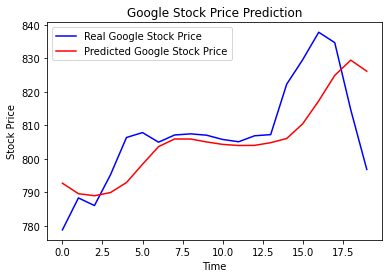

In [89]:
plt.plot(real_stock_price,color='blue',label='Real Google Stock Price')
plt.plot(predicted_Google_stock_price,color='red',label='Predicted Google Stock Price')
plt.legend()
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.savefig('rnn_pred.png')

Performance metrics

In [87]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_Google_stock_price))

In [88]:
rmse

11.73356917775519